# Assignment 2


In [1]:
import pickle
import pandas as pd
import urllib.request
import json
import math 
import ast
import re
from itertools import islice
from urllib.parse import quote

### Data

In [2]:
# 1. Load names/wiki links dictionary
def extractDataFiles(filename):
    marvel = pd.read_csv(filename +".csv")
    marvel_wikilinks = marvel.loc[:, 'WikiLink']
    marvel_characters = marvel_wikilinks[marvel_wikilinks.notna()].to_numpy()

    all_marvel = {}

    for name in marvel_characters:
        character = name.replace(" ", "_")
        all_marvel[character] = character

    return all_marvel

In [3]:
# 1. calling the functions
marvel = extractDataFiles('marvel')
dc = extractDataFiles('dc')

In [4]:
print(len(dc))
print(len(marvel))

518
1785


In [5]:
# 3. create URL with given character_wiki_link
# @returns NAME-> URL dict
def createURLs(data_dir): 
    
    url_query_list = {}
    
    for name,wiki in data_dir.items():        
        baseurl = "https://en.wikipedia.org/w/api.php?"
        action = "action=query"
        title = "titles=" + wiki
        content = "prop=revisions&rvprop=content"
        only_links = "prop=links&pllimit=max"
        dataformat ="format=json"
        
        query = "{}{}&{}&{}&{}&{}".format(baseurl, action, content, title,only_links, dataformat)
        url_query_list[name] = query
        
    
    return url_query_list

In [6]:
DC_url_query_directory_Links = createURLs(dc)
marvel_url_query_directory_Links = createURLs(marvel)

In [7]:
print(len(DC_url_query_directory_Links))
print(len(marvel_url_query_directory_Links))

518
1785


In [8]:
# 3.1 create URL with given character_wiki_link
# @returns NAME-> URL dict
def createURLsPages(data_dir): 
    
    url_query_list = {}
    
    for name,wiki in data_dir.items():        
        baseurl = "https://en.wikipedia.org/w/api.php?"
        action = "action=query"
        title = "titles=" + wiki
        content = "prop=revisions&rvprop=content"
        only_links = "&pllimit=max"
        dataformat ="format=json"
        
        query = "{}{}&{}&{}&{}&{}".format(baseurl, action, content, title,only_links, dataformat)
        url_query_list[name] = query
        
    
    return url_query_list

In [9]:
marvel_url_query_directory_pages = createURLsPages(marvel)
DC_url_query_directory_pages = createURLsPages(dc)

In [10]:

print(len(DC_url_query_directory_pages))


518


In [11]:
# 4. Send request

def sendWikiRequests(url_list):
    response_wiki_dir = {}

    for name,url in url_list.items():
        try:
            wikiresponse = urllib.request.urlopen(url)
            wikidata = wikiresponse.read()
            wikitext = wikidata.decode('utf-8')
        
            wiki_json = json.loads(wikitext)
            response_wiki_dir[name] = wiki_json
        except:
            pass
        
    return response_wiki_dir

In [12]:
DC_wiki_json_responses = sendWikiRequests(DC_url_query_directory_Links)
marvel_wiki_json_responses = sendWikiRequests(marvel_url_query_directory_Links)

In [13]:
marvel_wiki_responses_pages = sendWikiRequests(marvel_url_query_directory_pages)
dc_wiki_responses_pages = sendWikiRequests(DC_url_query_directory_pages)

In [14]:
def connectLinksPages(link_Directory,page_Directory):
    full_dict = {}
    
    for name, wiki in link_Directory.items():
        links = str(wiki)        
        pages = str(page_Directory[name])
        full = links + '***' + pages
        full_dict[name] = full
    return full_dict

In [15]:
dcFUll = connectLinksPages(DC_wiki_json_responses, dc_wiki_responses_pages) 

In [16]:
marvelFull = connectLinksPages(marvel_wiki_json_responses, marvel_wiki_responses_pages) 

In [17]:
# Save to file
import os.path

def saveWikiJsonFiles(name_wiki,universe):
    for name,wiki in name_wiki.items():
        
        save_path = str(universe)+'/'
        name = name.replace('|','')
        completeName = os.path.join(save_path, name+".txt")      
        try:
            with open(completeName, "w") as text_file:
                    text_file.write(str(wiki))
        except:
            pass        

In [18]:
saveWikiJsonFiles(marvelFull, 'marvel')

In [19]:
saveWikiJsonFiles(dcFUll, 'dc')

In [20]:
def readWikiJsonFiles(universe):
    
    name_wiki_json = {}
    
    for name in os.listdir(universe):
        complete_name = os.path.join(universe, name)
        try:
            with open(complete_name, "r") as character_file:
                f = character_file.read()
                name_wiki_json[name] = json.loads(json.dumps(f))
        except:
            pass
#             print("{} failed to be read.".format(complete_name))
    
    return name_wiki_json


In [21]:
DC_name_wiki = readWikiJsonFiles('dc')
marvel_name_wiki = readWikiJsonFiles('marvel')

In [22]:
# preprocessing full pages / links
def splitLinksPages(text_file_list):
    
    name_wiki_dict = {}
    
    for name, wiki in text_file_list.items():
        x = wiki.split("***")    
        name_wiki_dict[name] = x
    
    return name_wiki_dict

In [23]:
DC_name_wiki_processed = splitLinksPages(DC_name_wiki)
marvel_name_wiki_processed = splitLinksPages(marvel_name_wiki)


In [24]:
beforeClean = len(DC_name_wiki_processed)
beforeClean2 = len(marvel_name_wiki_processed)

print('before clean ' , beforeClean) # le nomber is OKE based on the CSV provided
print('before clean2 ' , beforeClean2) # le nomber is OKE based on the CSV provided

before clean  454
before clean2  1754


In [25]:

# 5. extractLinks for each title,
# @return array of names(links) to other pages
def extractNodeNeighbors(directory):
    
    linkList = []
    
    for i in range(len(directory)):
        ns = directory[i]['ns']
        if(int(ns) != 0):
            break
        else:
            title = directory[i]['title']
            linkList.append(title)
    
    return linkList

# 5.1 Check if site is redirect
def checkIfRedirect(directory):
    
    for i in range(len(directory)):
        ns = directory[i]['ns']
        if(int(ns) == 4):
            title = directory[i]['title']
            if "redirect" in title: 
                print('redirect')
                return 0
            else:
                return 1
        else:
            return 1

def wiki_json_preprocessing(directory):
    
    name_neighbors = {}
    
    for name,value_json in directory.items():
        try:
            value_json = value_json[0]
            value_json = ast.literal_eval(value_json)
        except:
            continue
        non_unique = value_json['query']['pages'].keys()
        non_unique = next(iter(non_unique))
        
        try:    
            link_dir = value_json['query']['pages'][non_unique]['links']
        except:
            continue
        #check for redirect
        
        try:
            if(checkIfRedirect(link_dir) == 0):
                print(directory[name] + ' DELETED')
                del directory[name]                
                continue
        except:
            pass
        else:
            node_neighbors = extractNodeNeighbors(link_dir)
                
        name_neighbors[name] = node_neighbors
        
    return name_neighbors      


In [26]:
marvel_name_nodeLinks = wiki_json_preprocessing(marvel_name_wiki_processed)
DC_name_nodeLinks = wiki_json_preprocessing(DC_name_wiki_processed)

In [27]:

print('after clean ', len(DC_name_nodeLinks))
print('after clean2 ', len(marvel_name_nodeLinks))


print('difference ', beforeClean - len(DC_name_nodeLinks))
print('difference2 ', beforeClean2 - len(marvel_name_nodeLinks))


after clean  435
after clean2  1744
difference  19
difference2  10


**For each link you extract, check if the target is a character from your DC/Marvel lists. If yes, keep it. If no, discard it.**

In [28]:
def checkFromTargetUniverse(character_nodes, universe):
    return list(set(character_nodes) & set(universe))

In [29]:
# Marvel check


def removeRandomCharacters(name_links): 
    summ = 0
    
    for name, links in name_links.items():
        x_dc = checkFromTargetUniverse(links, dc)
        x_marvel = checkFromTargetUniverse(links, marvel)
        
        x_final = list(set().union(x_dc, x_marvel))
        summ += len(x_final)
        name_links[name] = x_final
    
    print('key -> value ::: sum of all edges in the values field ', summ)
    
    return name_links



In [30]:
print('marvel')
marvel_name_nodeLinks = removeRandomCharacters(marvel_name_nodeLinks)
print('marvel nodes number : ', len((marvel_name_nodeLinks)))

print()
print('dc')
DC_name_nodeLinks = removeRandomCharacters(DC_name_nodeLinks)
print('DC nodes number ', len((DC_name_nodeLinks)))


marvel
key -> value ::: sum of all edges in the values field  22257
marvel nodes number :  1744

dc
key -> value ::: sum of all edges in the values field  6494
DC nodes number  435


#### Use a NetworkX DiGraph to store the network. As noted above, remember to store the properties of the nodes (i.e. from which universe they hail).


In [31]:
# IMPORTS
import networkx as nx

In [32]:
# G.add_node('abc', dob=1185, pob='usa', dayob='monday')

G = nx.DiGraph()

#marvel
for name in marvel_name_nodeLinks.keys():
    G.add_node(name, universe = 'marvel')

#dc
for name in DC_name_nodeLinks.keys():
    G.add_node(name, universe = 'dc')

for name, connections in marvel_name_nodeLinks.items(): 
    for i in range(len(connections)):
        G.add_edge(name, connections[i])
        
for name, connections in DC_name_nodeLinks.items(): 
    for i in range(len(connections)):
        G.add_edge(name, connections[i])

### Basic Stats

In [69]:
import numpy as np
from statistics import mode # numpy doesn't have mode and median API :(

# Get basic stats of the network
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())

# In degrees
degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)

print("In-degree average: ", np.average(degree_sequence))
print("In-degree mode: ", mode(degree_sequence))
print("In-degree median: ", np.median(degree_sequence))
print("In-degree min: ", np.min(degree_sequence))
print("In-degree max: ", np.max(degree_sequence))
print()

# Out degrees
degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True)
print("Out-degree average: ", np.average(degree_sequence))
print("Out-degree mode: ", mode(degree_sequence))
print("Out-degree median: ", np.median(degree_sequence))
print("Out-degree min: ", np.min(degree_sequence))
print("Out-degree max: ", np.max(degree_sequence))

Number of nodes:  2472
Number of edges:  28751
In-degree average:  11.630663430420713
In-degree mode:  0
In-degree median:  0.0
In-degree min:  0
In-degree max:  564

Out-degree average:  11.630663430420713
Out-degree mode:  0
Out-degree median:  4.0
Out-degree min:  0
Out-degree max:  54


Our network consists of 2472 nodes, and 28751 edges. Considering the in-degree distribution, the average in-degree is 11.63, both the mode and median are equal to 0, the minimum is 0, and the maximum is 564. It's quite interesting to see that majority of the nodes have an in-degree of 0, meaning that no other character refers to them, and the maximum is relatively high, which suggests a power law distribution. As for the out-degree, the average is exactly the same, 11.63, the mode is 0, the median is 4.0, the minimum is 0 and the maximum is 54. From this, we can see that the out-degree distribution is somewhat more flat -- in a way that the maximum is much smaller than that of in-degree, and the median is 4.0, as opposed to 0.

Values less than or equal to 0 in data. Throwing out 0 or negative values
/Users/kar/opt/anaconda3/lib/python3.8/site-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in log
  return 1 + len(data)/sum(log(data / (self.xmin)))


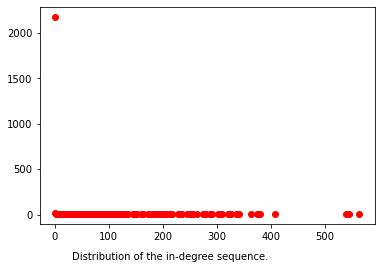

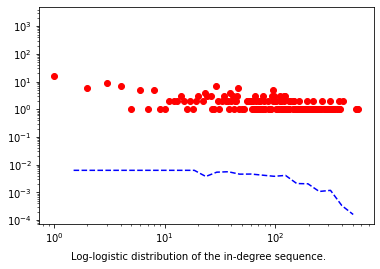

In [133]:
# Plotting in-degree distribution
# !pip install powerlaw
import powerlaw
import collections
import matplotlib.pyplot as plt
import numpy as np

# In degrees
degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)
degree_count = collections.Counter(degree_sequence)
in_degrees, in_counts = zip(*degree_count.items())

# Calculate the exponent of the degree distribution
fit = powerlaw.Fit(in_degrees, xmin=-500, xmax=20000)

fig, norm_ax = plt.subplots()
norm_ax.plot(in_degrees, in_counts, 'ro')
fig.text(.2, .002, "Fig 1: Distribution of the in-degree sequence.")
plt.show()

fig, loglog_ax = plt.subplots()
loglog_ax.loglog(in_degrees, in_counts, 'ro')
fit.plot_pdf(color= 'b', linestyle='--', ax=loglog_ax)
fig.text(.2, .002, "Fig 2: Log-logistic distribution of the in-degree sequence.")
plt.show()

The majority of the nodes have a degree of 0, while the few most-popular nodes have a very highe degree, as can be seen Fig 1. This resembles a scale free distribution, therefore, for the sake of better visualization, we plotted it as a loglog graph, along with the exponent of the degree distribution calculated using the powerlaw package, see Fig 2. These visualizations provide a useful insight into the network: We can see that a lot of characters refer to a very popular character -- such as Spider-Man -- while no other nodes refer to them.

Values less than or equal to 0 in data. Throwing out 0 or negative values
/Users/kar/opt/anaconda3/lib/python3.8/site-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in log
  return 1 + len(data)/sum(log(data / (self.xmin)))


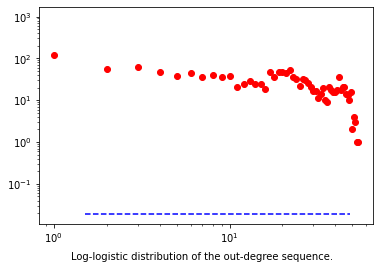

In [120]:
# Plotting out-degree distribution

degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True)
degree_count = collections.Counter(degree_sequence)
out_degrees, out_counts = zip(*degree_count.items())

# Calculate the exponent of the degree distribution
fit = powerlaw.Fit(out_degrees, xmin=-1000, xmax=1000)

fig, main_ax = plt.subplots()
main_ax.loglog(out_degrees, out_counts, 'ro')
fig.text(.2, .002, "Log-logistic distribution of the out-degree sequence.")
plt.show()

Reflecting on the slope...

In [82]:
# Plotting the network using ForceAtlas algorithm

# First, let's extract the giant connected component: it will be more interesting to visualize

subgraphs = [G.subgraph(c) for c in nx.weakly_connected_components(G)]
GCC = subgraphs[0]
for subgraph in subgraphs[1:]:
    if subgraph.number_of_nodes() > GCC.number_of_nodes():
        GCC = subgraph
        
GCC_undirected = GCC.to_undirected()

# Universe attribute
attributes_dict = {}
for i in marvel_name_nodeLinks.keys():
    attributes_dict[i] = "marvel"

for i in DC_name_nodeLinks.keys():
    attributes_dict[i] = "dc"

nx.set_node_attributes(GCC_undirected, attributes_dict, name="universe")

In [90]:
# !pip install fa2
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(GCC_undirected, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:33<00:00, 60.31it/s]

BarnesHut Approximation  took  13.00  seconds
Repulsion forces  took  18.14  seconds
Gravitational forces  took  0.17  seconds
Attraction forces  took  0.48  seconds
AdjustSpeedAndApplyForces step  took  0.64  seconds


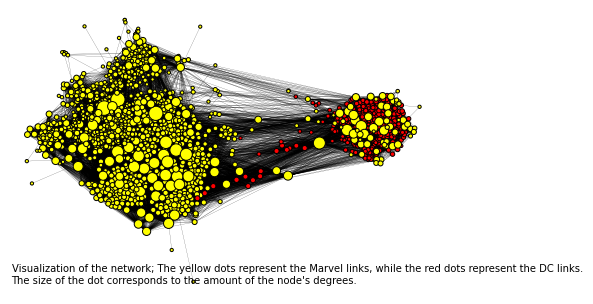

In [108]:
import collections

node_colors = []

for node in list(GCC_undirected.nodes()):
    if node in DC_name_nodeLinks:
        node_color = "#FF0000"
    else:
        node_color = "#FFFF00"
    node_colors.append(node_color)

degree_sequence = [d for n, d in GCC_undirected.degree()]
degree_count = collections.Counter(degree_sequence)

offset = 10
scale = 200
degree_range = float(max(degree_sequence) - min(degree_sequence))
node_sizes = [offset + scale * degree / degree_range for degree in degree_sequence]

fig = plt.figure()
nx.draw(GCC_undirected, pos=positions, node_size=node_sizes, node_color=node_colors, width=0.15, edgecolors="#000000", linewidths=1)
caption = """
Visualization of the network; The yellow dots represent the Marvel links, while the red dots represent the DC links. 
The size of the dot corresponds to the amount of the node's degrees.
"""
fig.text(0.01, 0.0001, caption)
plt.show()

### Communities

### Sentiment